# Lorenz 96 Ginelli Workbook

This notebook is a space for quick investigations & current implementation notes. Less formal.

In [1]:
# Imports

import numpy as np
import time as tm
import xarray as xr
import sys
import ipywidgets as widgets
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
from ginelli96 import Ginelli96
from utilities import * # process object does averaging

In [ ]:
# Progress Bar Import

def in_notebook():
    """
    Returns ``True`` if the module is running in IPython kernel,
    ``False`` if in IPython shell or other Python shell.
    """
    return 'ipykernel' in sys.modules

if in_notebook():
    from tqdm.notebook import tqdm #tqdm is progress bar
else:
    from tqdm import tqdm

### Notes

Currently:

- Processing utilities
- Checkpointing

Then:

- To stitch runs together will be hard. Worth figuring first how long a run you need.
- Need to formalise memory job sizing
- Would be nice to stitch runs together
- Calculate and store CLV angles
- Determine run lengths, maybe we need to have a way to stitch many runs together
- See effect of changing $h$

## Testing Checkpointing

In [20]:
runner = Ginelli96(K = 2, J = 2, transient = 1, kA = 2, kB = 5 , kC = 2)
runner._run_ginelli()
raw = runner.run_data

Transient Beginning

Transient took 0.29691553115844727 seconds. Starting Ginelli Step 1.

Step 1 took 0.5506072044372559 seconds. Starting Ginelli Step 2.

Step 2 took 1.306870937347412 seconds. Starting Ginelli Step 3.

Step 3 took 0.5025069713592529 seconds. Starting Ginelli Step 4.

Step 4 took 0.0021877288818359375 seconds. Starting Ginelli Step 5.

Step 5 took 0.0009167194366455078 seconds. Finishing up.



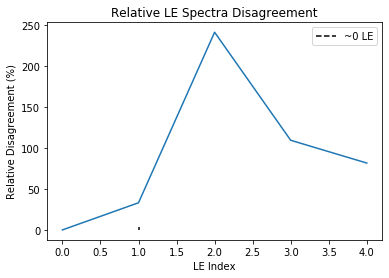

In [35]:
# Seeing if error between CLE and BLE difference is gone
plt.plot(100 * np.abs((processed.CLE - processed.BLE)[:-1]/(processed.BLE)[:-1]))
#plt.plot(100 * np.abs((processed.CLE - processed.BLE)/(processed.BLE)))
plt.plot(np.full_like(np.linspace(-0.5, 3.55, 100), processed.kd),np.linspace(-0.01, 3.6, 100), '--k', label = '~0 LE')
plt.title('Relative LE Spectra Disagreement')
plt.ylabel('Relative Disagreement (%)')
plt.legend()
plt.xlabel('LE Index')
plt.savefig('CLE-vs-BLE-Spectra.png', dpi = 1200)

In [ ]:
# Function plotting FTLE density for changing
le = 150
ftle = 'C'
for data in L_data:
    avg_time = data.attrs['Avg Time'] # for now L = 1

    # FTCLE or FTBLE?
    if (ftle == 'C'):
        FTLE = data.FTCLE.sel(le_index = le).values
        label = f'{avg_time:.2f}'
    else: # then FTBLE
        FTLE = data.FTCLE.sel(le_index = le).values
        label = f'$h={h:.2f}$'

    x_d = np.linspace(FTLE.min() - 1, FTLE.max() + 1, 100) # Grid we evaluate PDF on
    kde = gaussian_kde(FTLE) # KDE. Using Gaussian kernels with default bandwidth, don't know how it decided bw?
    pdf = kde.evaluate(x_d)
    plt.plot(x_d, pdf, label = label) 

    plt.xlabel(f'FT{ftle}LE')
    plt.ylabel('$\\rho$')
    plt.title(f'FT{ftle}LE {le} Density Comparison')
plt.plot(np.full_like(np.linspace(0,1, 10), processed.CLE.sel(le_index = le)), np.linspace(0,1, 10) ,'--k', label = 'Mean')
plt.legend()
plt.show()


In [ ]:
long_data = xr.open_dataset(